# Figures

This notebook generates the figures used in the HotPotQA RAG example. It's messy, but if you change the indices you can try out other responses

View the HotPotQA dataset: https://hotpotqa.github.io/

In [ ]:
import os
import json
from dotenv import load_dotenv
from datasets import load_dataset
from openai import OpenAI
from bert_score import score as bertscore
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import RougeScore
from ragas.metrics import BleuScore
import warnings


# Load API key from .env
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [140]:
# Load the HotpotQA dataset
dataset = load_dataset("hotpot_qa", "fullwiki")  # or "distractor"

# Access train/dev splits
data = dataset["validation"]

# Example: print first record
print(data[0])


{'id': '5a8b57f25542995d1e6f1371', 'question': 'Were Scott Derrickson and Ed Wood of the same nationality?', 'answer': 'yes', 'type': 'comparison', 'level': 'hard', 'supporting_facts': {'title': ['Scott Derrickson', 'Ed Wood'], 'sent_id': [0, 0]}, 'context': {'title': ['Adam Collis', 'Ed Wood (film)', 'Tyler Bates', 'Doctor Strange (2016 film)', 'Hellraiser: Inferno', 'Sinister (film)', 'Deliver Us from Evil (2014 film)', 'Woodson, Arkansas', 'Conrad Brooks', 'The Exorcism of Emily Rose'], 'sentences': [['Adam Collis is an American filmmaker and actor.', ' He attended the Duke University from 1986 to 1990 and the University of California, Los Angeles from 2007 to 2010.', ' He also studied cinema at the University of Southern California from 1991 to 1997.', ' Collis first work was the assistant director for the Scott Derrickson\'s short "Love in the Ruins" (1995).', ' In 1998, he played "Crankshaft" in Eric Koyanagi\'s "Hundred Percent".'], ['Ed Wood is a 1994 American biographical peri

In [142]:
def get_context(dataj:json) -> str:
    # Concatenates all the retrieved context with document titles
    joined_context = "---\n---".join(
        f"Title: {title}, Contents: {' | '.join(sentences)}"
        for title, sentences in zip(dataj['context']['title'], dataj['context']['sentences'])
    )
    return joined_context

get_context(data[0])

'Title: Adam Collis, Contents: Adam Collis is an American filmmaker and actor. |  He attended the Duke University from 1986 to 1990 and the University of California, Los Angeles from 2007 to 2010. |  He also studied cinema at the University of Southern California from 1991 to 1997. |  Collis first work was the assistant director for the Scott Derrickson\'s short "Love in the Ruins" (1995). |  In 1998, he played "Crankshaft" in Eric Koyanagi\'s "Hundred Percent".---\n---Title: Ed Wood (film), Contents: Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. |  The film concerns the period in Wood\'s life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau. |  Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.---\n---Title: Tyler Bates, Contents: Tyler Bates (born June 5,

In [143]:
# Load API key from .env
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Load HotpotQA JSON from local file
def load_hotpotqa_dataset(file_path):
    return load_dataset("json", data_files=file_path)["train"]

# Query GPT-4o with question and context
def query_gpt4o_with_hotpotqa(index, dataset):
    record = dataset[index]

    # Assemble context text
    context_text = get_context(record)

    # Create the RAG-style prompt
    prompt = f"""You are an expert question-answering system.
Use the context provided to answer the question as accurately as possible.
If the answer is not in the context, say "I don't know."

Context:
{context_text}

Question: {record["question"]}
Answer:"""

    # Send the prompt to GPT-4o
    response = client.responses.create(
        model="gpt-4o",
        input=prompt
    )

    answer = response.output[0].content[0].text
    return prompt, answer 

def llm_judge(answer, reference, question):
    prompt = f"""You are an expert evaluator of question-answering
systems. Compare the following answer from an AI to the reference
answer provided by an expert human. Determine whether they are
factually equivalent even if they are worded differently
Answer only 1 for same or 0 for different. Do not provide any
other commentary
Question: {question}
Reference: {reference}
Proposed Answer" {answer}
"""
    
    # Send the prompt to GPT-4o
    response = client.responses.create(
        model="gpt-4o",
        input=prompt
    )

    answer = response.output[0].content[0].text
    return answer 


In [144]:
llm_judge("Arthur's Magazine was started second", "Arthur's Magazine", "Which magazine was started first Arthur\'s Magazine or First for Women?")

'0'

In [145]:
print(query_gpt4o_with_hotpotqa(index=0, dataset=data))

('You are an expert question-answering system.\nUse the context provided to answer the question as accurately as possible.\nIf the answer is not in the context, say "I don\'t know."\n\nContext:\nTitle: Adam Collis, Contents: Adam Collis is an American filmmaker and actor. |  He attended the Duke University from 1986 to 1990 and the University of California, Los Angeles from 2007 to 2010. |  He also studied cinema at the University of Southern California from 1991 to 1997. |  Collis first work was the assistant director for the Scott Derrickson\'s short "Love in the Ruins" (1995). |  In 1998, he played "Crankshaft" in Eric Koyanagi\'s "Hundred Percent".---\n---Title: Ed Wood (film), Contents: Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. |  The film concerns the period in Wood\'s life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by M

In [168]:
async def evaluate_generated_answer(hotpot_record, generated_answer):
    reference = hotpot_record["answer"].strip()
    candidate = generated_answer.strip()

    # RAGAS BLEU and ROUGE
    sample = SingleTurnSample(response=candidate, reference=reference)

    bleu = await BleuScore().single_turn_ascore(sample)
    rouge = await RougeScore(rouge_type="rouge1").single_turn_ascore(sample)

    # BERTScore F1
    P, R, F1 = bertscore([candidate], [reference], lang="en", rescale_with_baseline=True)
    bert_f1 = F1[0].item()

    # BERTScore similarity plot
    plot_example(candidate, reference, lang="en", rescale_with_baseline=True)

    # LLM judge
    judge_binary = llm_judge(candidate, reference, hotpot_record["question"])

    print(f"BLEU (RAGAS): {bleu:.3f}")
    print(f"ROUGE (RAGAS): {rouge:.3f}")
    print(f"BERTScore-F1: {bert_f1:.3f}")

    return {
        "bleu": bleu,
        "rouge": rouge,
        "bert_f1": bert_f1,
        "llm judge": judge_binary,
        "question": hotpot_record["question"],
        "reference": reference,
        "candidate": candidate
    }

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.

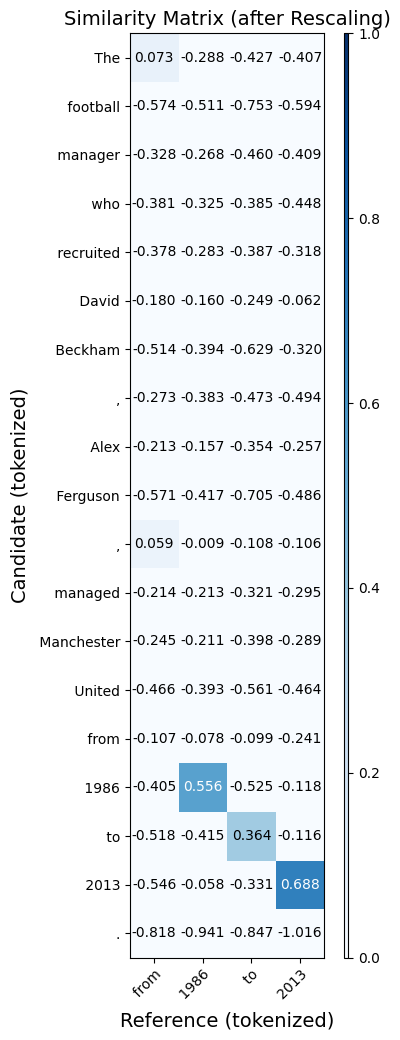

BLEU (RAGAS): 0.127
ROUGE (RAGAS): 0.400
BERTScore-F1: 0.223
{'bleu': 0.12673718536830808, 'rouge': 0.4, 'bert_f1': 0.2230186015367508, 'llm judge': '1', 'question': 'The football manager who recruited David Beckham managed Manchester United during what timeframe?', 'reference': 'from 1986 to 2013', 'candidate': 'The football manager who recruited David Beckham, Alex Ferguson, managed Manchester United from 1986 to 2013.'}


In [166]:
index = 14
_, answer = query_gpt4o_with_hotpotqa(index=index, dataset=data)
result = await evaluate_generated_answer(data[index], answer)

print(result)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.

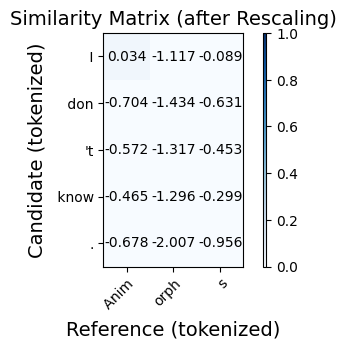

BLEU (RAGAS): 0.000
ROUGE (RAGAS): 0.000
BERTScore-F1: -0.114
{'bleu': 0.0, 'rouge': 0.0, 'bert_f1': -0.11426025629043579, 'LLM Judge': '0', 'reference': 'Animorphs', 'candidate': "I don't know."}


In [148]:
index = 2
_, answer = query_gpt4o_with_hotpotqa(index=index, dataset=data)
result = await evaluate_generated_answer(data[index], answer)

print(result)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.

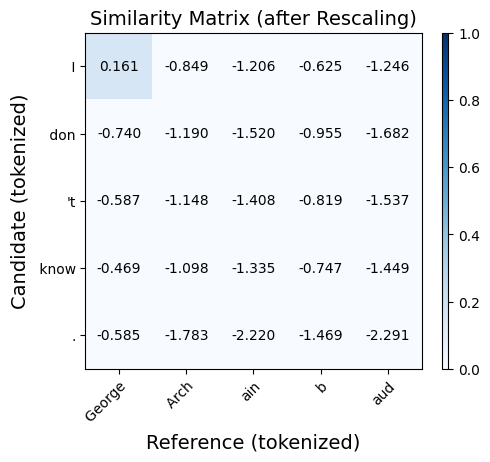

BLEU (RAGAS): 0.000
ROUGE (RAGAS): 0.000
BERTScore-F1: -0.377
{'bleu': 0.0, 'rouge': 0.0, 'bert_f1': -0.37740546464920044, 'llm judge': '0', 'question': 'Who died first, George Archainbaud or Ralph Murphy?', 'reference': 'George Archainbaud', 'candidate': "I don't know."}


In [167]:
index = 113
_, answer = query_gpt4o_with_hotpotqa(index=index, dataset=data)
result = await evaluate_generated_answer(data[index], answer)

print(result)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.

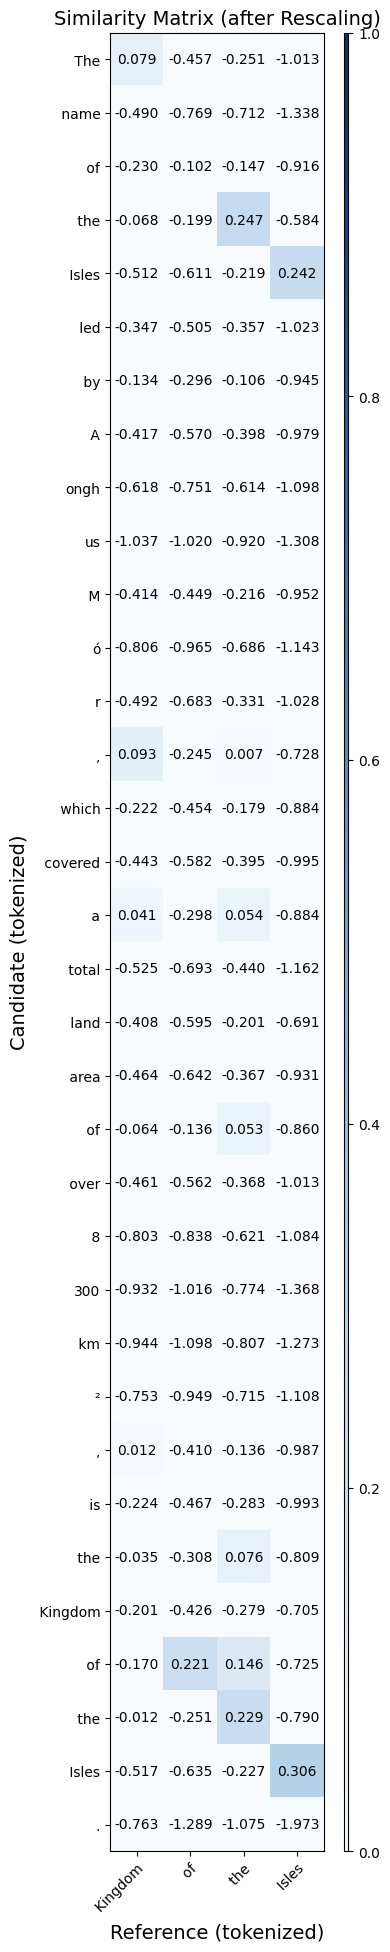

BLEU (RAGAS): 0.084
ROUGE (RAGAS): 0.267
BERTScore-F1: 0.015
{'bleu': 0.08359764098433711, 'rouge': 0.2666666666666667, 'bert_f1': 0.014514956623315811, 'LLM Judge': '1', 'reference': 'Kingdom of the Isles', 'candidate': 'The name of the Isles led by Aonghus Mór, which covered a total land area of over 8300 km², is the Kingdom of the Isles.'}


In [150]:
index = 147
_, answer = query_gpt4o_with_hotpotqa(index=index, dataset=data)
result = await evaluate_generated_answer(data[index], answer)

print(result)

In [ ]:
P, R, F1 = bertscore(["Mine canis familiaris is Zoe"], ["My dog's name is Zoe"], lang="en", rescale_with_baseline=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.0715]), tensor([0.3231]), tensor([0.1955]))

In [186]:
bertscore(["I have a dog named Zoe"], ["My dog's name is Zoe"], lang="en", rescale_with_baseline=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


(tensor([0.6707]), tensor([0.5579]), tensor([0.6143]))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


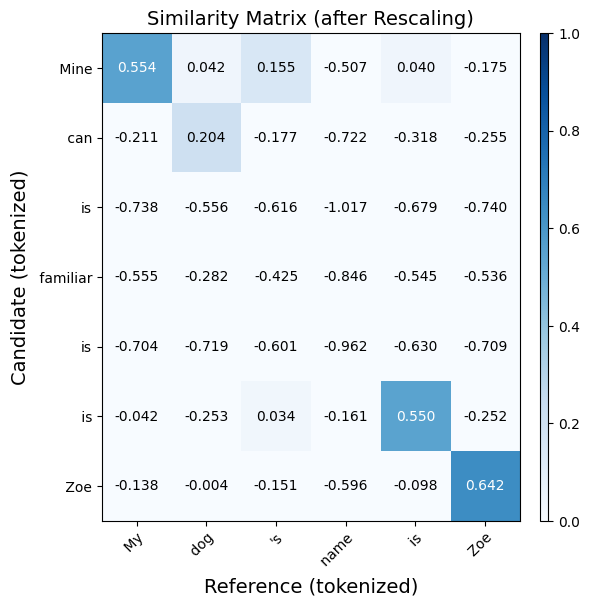

In [ ]:
from bert_score import plot_example
plot_example("Mine canis familiaris is Zoe", "My dog's name is Zoe", lang="en", rescale_with_baseline=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


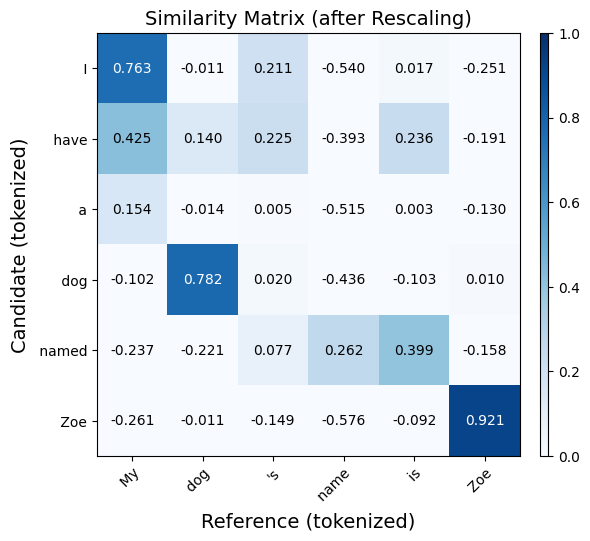

In [185]:
from bert_score import plot_example
plot_example("I have a dog named Zoe", "My dog's name is Zoe", lang="en", rescale_with_baseline=True)